Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# This notebook unzippes the data files and explores them and creates the Train, Validation and Test sets 

In [3]:
%matplotlib inline
import numpy as np
import os
import pickle
import azureml.core
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from zipfile import ZipFile
from matplotlib import image, pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import np_utils


# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.27.0


### Only Once - unzip the data

In [4]:
data_folder2 = os.path.join(os.getcwd(), 'dataLH')
file_name='Training.zip'
zippedFile=os.path.join(data_folder2, file_name)

In [5]:
def unzipData(zippedFile):
    with ZipFile(zippedFile, 'r') as zz:
        zz.extractall()
        

In [6]:
file_name='Training.zip'
zippedFile=os.path.join(data_folder2, file_name)
unzipData(zippedFile)

file_name='Testing.zip'
zippedFile=os.path.join(data_folder2, file_name)
unzipData(zippedFile)

In [7]:
unzippedTrain=os.path.join(os.getcwd(),'Training')
unzippedTest=os.path.join(os.getcwd(),'Testing')
print(unzippedTrain)
print(os.listdir(unzippedTrain))

c:\Users\ankubasi\OneDrive - Microsoft\Documents\Sandbox\20210407_LH_demo_new\DNNdemo\Training
['4U', 'Background', 'EW', 'LH_new', 'LH_old', 'LH_veryold', 'LX', 'OS']


### Visualize Trainig Data

In [8]:
unzipped=unzippedTrain

c:\Users\ankubasi\OneDrive - Microsoft\Documents\Sandbox\20210407_LH_demo_new\DNNdemo\Training\4U


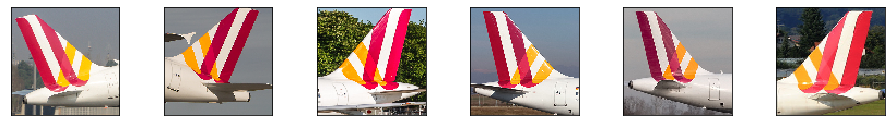

c:\Users\ankubasi\OneDrive - Microsoft\Documents\Sandbox\20210407_LH_demo_new\DNNdemo\Training\LH_new


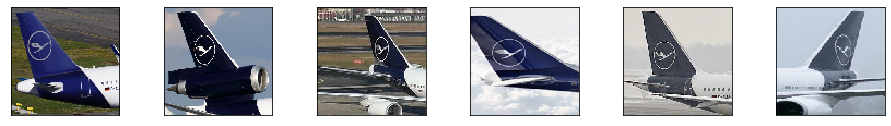

In [9]:
subfolders=os.listdir(unzipped)

fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(16, 2),
        subplot_kw={'xticks': [], 'yticks': []})
i=0
for uf in subfolders[0:1]:
    folderPath=os.path.join(unzipped,uf)
    print(folderPath)
    for ff in os.listdir(folderPath)[1:7]:
        filePath=os.path.join(folderPath,ff)
        image = load_img(filePath, target_size=(100, 100))
        ax=axs[i]
        ax.imshow(image)
        i=i+1

plt.show()        

fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(16, 2),
        subplot_kw={'xticks': [], 'yticks': []})
i=0
for uf in subfolders[3:4]:
    folderPath=os.path.join(unzipped,uf)
    print(folderPath)
    for ff in os.listdir(folderPath)[1:7]:
        filePath=os.path.join(folderPath,ff)
        image = load_img(filePath, target_size=(100, 100))
        ax=axs[i]
        ax.imshow(image)
        i=i+1

plt.show()        

### Convert images to list of np.array

In [10]:
from PIL import Image
def image2data(unzipped='',target_size=(150,150), normalize=True, folder='train',greyscale=False):
    ncol=150
    nrow=150
    nchannels=3
    
    y=list()
    x=list()
    fileIndex=list()
    
    for uf in os.listdir(unzipped):
        folderPath=os.path.join(unzipped,uf)
        print(uf)
        for ff in os.listdir(folderPath):
            if ff[0]=='.': continue 
            filePath=os.path.join(folderPath,ff)
        
            image = load_img(filePath, target_size=target_size,grayscale=greyscale)
            data=img_to_array(image)
            if normalize: data=data/255
            #if greyscale: data = data[:,:,0]
            x=x+[data]        
            y=y+[uf]
            fileIndex=fileIndex+[filePath]
    x=np.array(x)
    y=np.array(y)

    ##################################### one hot encoding for the labels in needed in Keras
    print('')
    print('Encoding targets')
    
    # encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)
    # convert integers to dummy variables (i.e. one hot encoded)
    dummy_y = np_utils.to_categorical(encoded_y)

    
    ############################################################################################
    if folder == 'train':
        print('')
        print('Splittint train and validation sets')
    
        x_train, x_val, y_train, y_val = train_test_split(x, dummy_y, test_size=0.2, random_state=42)
        #x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
        allsets={'x_train':x_train,'x_val':x_val,'y_train':y_train,'y_val':y_val}
    else: 
        x_test=x
        y_test=y
        allsets={'x_test':x_test,'y_test':y_test}     
    
    print('')
    print('Writing files')
    
    outputFolder= folder+'Dataset'
    os.makedirs(outputFolder, exist_ok=True)
    
    for n in allsets:
            filename= n+'.tsv'
            print(filename,allsets[n].shape)
            with open(os.path.join(outputFolder, filename),"wb") as f:
                 pickle.dump(allsets[n],f)
                    
    if folder =='train':   
        with open(os.path.join(outputFolder, "encoder"),"wb") as f:
             pickle.dump(encoder,f)
    


In [11]:
image2data(unzipped=unzippedTrain,folder='train')

4U
Background
EW
LH_new
LH_old
LH_veryold
LX
OS

Encoding targets

Splittint train and validation sets

Writing files
x_train.tsv (1025, 150, 150, 3)
x_val.tsv (257, 150, 150, 3)
y_train.tsv (1025, 8)
y_val.tsv (257, 8)


In [12]:
image2data(unzipped=unzippedTest,folder='test')

4U
Background
EW
LH_new
LH_old

Encoding targets

Writing files
x_test.tsv (12, 150, 150, 3)
y_test.tsv (12,)


## Register Datasets

In [13]:
project_folder=os.getcwd()
train_data_folder='trainDataset'
test_data_folder='testDataset'
script_folder = os.path.join(os.getcwd(), "scripts")
#script_folder=project_folder # for now I keep the scripts in the main folder
os.makedirs(script_folder, exist_ok=True)

In [14]:
from azureml.core import Workspace
import azureml.core
ws = Workspace.from_config()
ws = Workspace(subscription_id='ed940d3a-1d48-4740-b2cb-bd9fe6642e7b' ,resource_group='20191107_DNNhyperdrive', workspace_name = 'WS1' )


If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


In [15]:
ds = ws.get_default_datastore()

ds.upload(src_dir=train_data_folder, target_path='trainDataset', overwrite=True, show_progress=True)
ds.upload(src_dir=test_data_folder, target_path='testDataset', overwrite=True, show_progress=True)

print(ds.datastore_type, ds.account_name, ds.container_name)
print(ws.name, ws.location, ws.resource_group, ws.location, sep='\t')


Uploading an estimated of 5 files
Uploading trainDataset\encoder
Uploaded trainDataset\encoder, 1 files out of an estimated total of 5
Uploading trainDataset\y_train.tsv
Uploaded trainDataset\y_train.tsv, 2 files out of an estimated total of 5
Uploading trainDataset\y_val.tsv
Uploaded trainDataset\y_val.tsv, 3 files out of an estimated total of 5
Uploading trainDataset\x_val.tsv
Uploaded trainDataset\x_val.tsv, 4 files out of an estimated total of 5
Uploading trainDataset\x_train.tsv
Uploaded trainDataset\x_train.tsv, 5 files out of an estimated total of 5
Uploaded 5 files
Uploading an estimated of 2 files
Uploading testDataset\y_test.tsv
Uploaded testDataset\y_test.tsv, 1 files out of an estimated total of 2
Uploading testDataset\x_test.tsv
Uploaded testDataset\x_test.tsv, 2 files out of an estimated total of 2
Uploaded 2 files
AzureBlob ws11078562529 azureml-blobstore-15002b44-9629-4d8c-a66d-71dde33561ab
WS1	westeurope	20191107_DNNhyperdrive	westeurope


In [16]:
from azureml.core import Dataset
trainDataset = Dataset.File.from_files((ds, 'trainDataset/*'))
testDataset = Dataset.File.from_files((ds, 'testDataset/*'))

In [17]:
for dsname in ['train','test']:
    print(dsname)
    dslongname=dsname+'Dataset'
    dataset_registered = False
    try:
        temp = Dataset.get_by_name(workspace = ws, name = dslongname)
        dataset_registered = True
        print('............. found registered')
        print(temp.to_path())
    except:
        print("The dataset "+dslongname+" is not registered in workspace yet.")

    if not dataset_registered:
        dataset = Dataset.File.from_files((ds, dsname+'Dataset/*'))
        dataset = dataset.register(workspace = ws,
                                name = dslongname,
                                description=dsname + 'dataset',
                                create_new_version=True)
        # list the files referenced by dataset
        print(dataset.to_path())
    

train
............. found registered
['/encoder', '/x_train.tsv', '/x_val.tsv', '/y_train.tsv', '/y_val.tsv']
test
............. found registered
['/encoder', '/x_test.tsv', '/x_train.tsv', '/x_val.tsv', '/y_test.tsv', '/y_train.tsv', '/y_val.tsv']


## Next step - train the model and register it